In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal

In [2]:
V0 = 36
E = np.linspace(-V0, 0, 100000)

In [3]:
RHS = np.sqrt(-E)
LHS1 = np.sqrt(E+V0)*np.tan(np.sqrt(E+V0))
LHS2 = -np.sqrt(E+V0)/np.tan(np.sqrt(E+V0+1e-10))

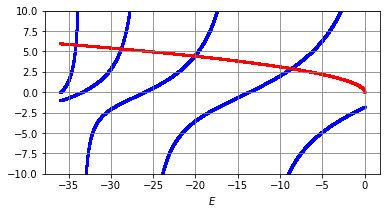

In [4]:
fig = plt.figure(figsize = (6,3))
plt.scatter(E, LHS1, s = 1, color = 'blue') # s is the size
plt.scatter(E, LHS2, s = 1, color = 'blue')
plt.scatter(E, RHS, s = 1, color = 'red')
plt.ylim(-10, 10)
plt.grid(color = 'grey')
plt.xlabel('$E$')
plt.show()

In [5]:
# Look for the intersection point! f(E, V0) = 0 ⇨ E is one of the energy spectrum
def f1(E, V0):
    return np.sqrt(E+V0)*np.tan(np.sqrt(E+V0)) - np.sqrt(-E)

def f2(E, v0, eps=1e-10):
    return np.sqrt(E+V0+eps)/np.tan(np.sqrt(E+V0+eps)) + np.sqrt(-E)

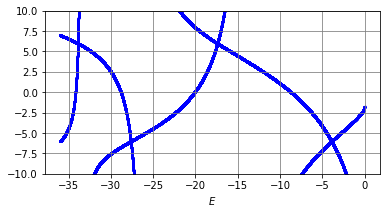

In [6]:
fig = plt.figure(figsize = (6,3))
plt.scatter(E, f1(E,V0), s = 1, color = 'blue') # s is the size
plt.scatter(E, f2(E,V0), s = 1, color = 'blue')
plt.ylim(-10, 10)
plt.grid(color = 'grey')
plt.xlabel('$E$')
plt.show()

In [7]:
#Now, Let's find a f(E) = 0 point.
f1s = f1(E, V0) # get array
f2s = f2(E, V0)

#np.where gives you the "index of non-zero point"!
# np.sign gives you the sign of the arrays
# np.diff takes the difference of next-to-next points.
# so np.where(np.diff(np.sign(f))) gives you the index of f = 0 point!!
# Only f = 0 point, np.diff(np.sign) is non-zero
# But actually there's another point, because of the tangent, by exclude those points by set <3!

print(np.sign(f1s))
print(np.diff(np.sign(f1s)))
print(np.where(np.diff(np.sign(f1s))))

[-1. -1. -1. ... -1. -1. -1.]
[0. 0. 0. ... 0. 0. 0.]
(array([ 5023,  6853, 44129, 61684]),)


In [8]:
len((np.abs(f1s)<3).astype(float))

100000

In [9]:
len((np.abs(f1s)<3).astype(float)[:-1])

99999

In [10]:
len(np.diff(f1s))

99999

In [11]:
f1s = f1(E, V0) # get array
f2s = f2(E, V0)


zero_crossings_f1s = np.where((np.abs(f1s)<3).astype(float)[:-1] * np.diff(np.sign(f1s)))[0]
zero_crossings_f2s = np.where((np.abs(f2s)<3).astype(float)[:-1] * np.diff(np.sign(f2s)))[0]
zero_crossings = np.sort(np.concatenate([zero_crossings_f1s, zero_crossings_f2s]))
Es_method1 = (E[zero_crossings] + E[zero_crossings+1])/2

In [12]:
N = 100000
x = np.linspace(-3, 3, N)
dx = np.diff(x)[0]
dx

6.0000600006215876e-05

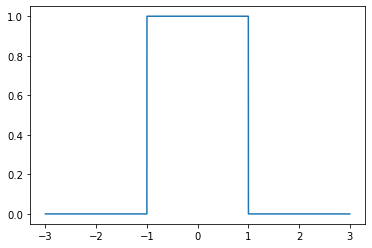

In [13]:
# Below gives  nonzero only inside the well, -1<x<1
plt.plot(x, ((x >= -1)*(x <= 1) ).astype(float) )
plt.show()

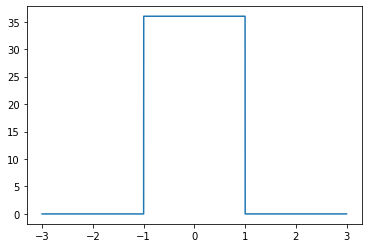

In [14]:
potential_diag = V0*((x >= -1)*(x <= 1) ).astype(float)
plt.plot(x, potential_diag)
plt.show()

In [15]:
# Diagonal matrix elements
main_diag = 2*np.ones(N)/dx**2 - V0*((x >= -1)*(x <= 1)).astype(float)

# boundary condition ψ1 = ψN = 0 but those are not the position of the wall!
main_diag[0] = -1/dx**2
main_diag[-1] = -1/dx**2

off_diag = - np.ones(N-1)/dx**2

In [16]:
# This method is valid only for tridiagonal matrix!!
Es_method2, psis = eigh_tridiagonal(main_diag, off_diag, select = 'v', select_range = (-V0,0))

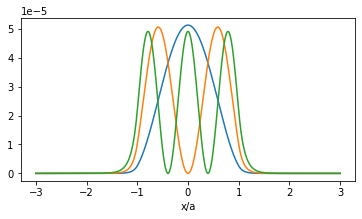

In [17]:
# Don't forget to take transpose!

plt.figure(figsize = (6, 3))
for i in range(0,3):
    plt.plot(x, np.abs(psis.T[i])**2)
plt.xlabel('x/a')
plt.show()

In [18]:
Es_method2

array([-34.19173723, -28.82448397, -20.11396889,  -8.69047838])

In [19]:
Es_method1

array([-34.19152192, -28.82422824, -20.11322113,  -8.68922689])

In [20]:
errs = 100 * np.abs(Es_method1 - Es_method2)/(1/2 * (Es_method1+Es_method2))
errs

array([-0.00062972, -0.00088719, -0.00371766, -0.01440168])

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.interpolate import interp1d
from scipy.integrate import quad

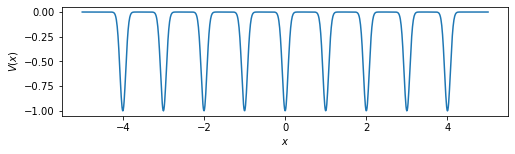

In [22]:
x = np.linspace(-5,5,1000)
y = np.sum([-np.exp(-(x-a)**2/0.01) for a in range(-4,5)], axis = 0)
plt.figure(figsize = (8, 2))
plt.plot(x,y)
plt.ylabel('$V(x)$')
plt.xlabel('$x$')
plt.show()

In [23]:
def solve_single_well(x, V, V0):
    N = len(x)
    dx = np.diff(x)[0]
    main_diag = 2*np.ones(N)/dx**2 + V(x,V0)
    off_diag = -np.ones(N-1)/dx**2
    Es, psis = eigh_tridiagonal(main_diag, off_diag, select = 'v', select_range = (-V0,0))
    psis = psis/np.sqrt((np.abs(psis)**2).sum(axis=0)*dx)
    return Es, psis.T

In [24]:
'''Dimensionfull parameters'''
V0 = 1 # eV
hbar = 6.582112e-16 # eV s
m = 0.510999e6/ (3e8)**2 # eV s^2 / m^2
a = 0.35e-9 / 2 # m
f = hbar**2 / (2*m*a**2)
'''Dimensionless parameters'''
V0 = V0 / f
b = 3 * 2

In [25]:
example = 1
N = 100000
x = np.linspace(-15,15,N)

if example == 1 or example == 2:
    def V(x, V0):
        return - V0*np.array((x >= -1)*(x <= 1), dtype = float)
elif example == 3:
    def V(x, V0):
        return - V0*np.exp(-(3*x)**2)

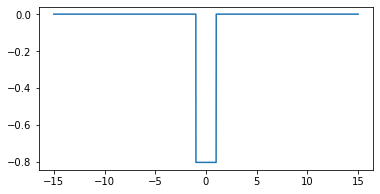

In [26]:
plt.figure(figsize = (6,3))
plt.plot(x, V(x, V0))
plt.show()

In [27]:
Es, psis = solve_single_well(x, V, V0)

In [28]:
f*Es

array([-0.40575739])

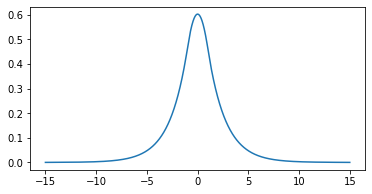

In [29]:
plt.figure(figsize = (6, 3))
[plt.plot(x, psi) for psi in psis]
plt.show()

In [30]:
# Let's interpolate here!!
func = interp1d(x, psis[0], bounds_error = False, fill_value = (0,0)) 
# Those argumets take care of the values out of x!!

In [31]:
# Interpolate all the psis
psis_f = [interp1d(x, psi, bounds_error = False, fill_value=(0,0)) for psi in psis]

In [32]:
psis_f[0](2)

array(0.26258615)

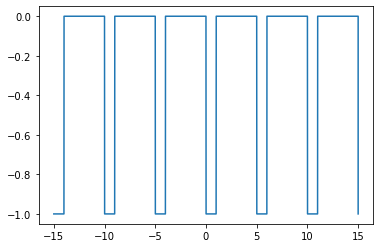

In [33]:
plt.plot(x, V(x%5,1))
plt.show()

In [34]:
def Vp_f(x,b,V0): # b is the distance between atoms
    return V((x + b/2)%b -b/2, V0) - V(x,V0)

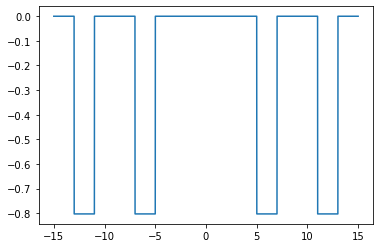

In [35]:
plt.plot(x, Vp_f(x,b,V0))
plt.show()

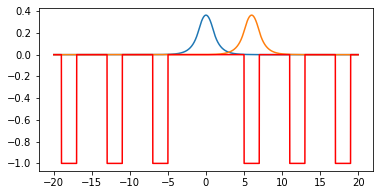

In [36]:
x_large = np.linspace(-20,20,10000)
plt.figure(figsize = (6,3))
plt.plot(x_large, psis_f[0](x_large)**2)
plt.plot(x_large, psis_f[0](x_large - b)**2)
plt.plot(x_large, Vp_f(x_large, b, V0)/V0, color = 'red')
plt.show()

In [37]:
def compute_integral(psis_f, Es, i1, i2, b, V0, n): # quad is the module for integration
    return quad(lambda x: psis_f[i1](x)*psis_f[i2](x-n*b)*(Es[i1]+Vp_f(x,b,V0)), # This is the matrix elements!!
            -20, 20, points = [n*b for n in range(-6, 6)], limit = 1000)[0]

In [38]:
f*compute_integral(psis_f, Es, 0, 0, b = 6, V0 = V0, n = 1)

-0.09757420376480629

In [39]:
# Fill the Hamiltonian

In [40]:
N_wells = 20
N_states = len(Es)
H = np.zeros((N_wells*N_states, N_wells*N_states))

In [41]:
H

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [42]:
# Fill off diagonal
psis_tot = N_wells*psis_f #20個
Es_tot = N_wells*list(Es)
for i1 in range(H.shape[0]):
    for i2 in range(i1, H.shape[0]):
        well1_idx = i1//N_states # Those are the spacing of the atoms!! Important
        well2_idx = i2//N_states #あとで使うかも # // is the floor division!
        H[i1,i2] = compute_integral(psis_tot, Es_tot, i1, i2, b=b,V0=V0, n=well2_idx-well1_idx)
        
H += H.T

In [43]:
# Fill main diagonal
main_diag = np.array(list(Es)*N_wells)
H[np.diag_indices(H.shape[0])] = main_diag

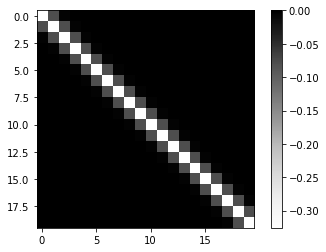

In [44]:
plt.imshow(H, cmap = 'Greys')
plt.colorbar()
plt.show()

In [45]:
eigenenergies , eigenvectors = np.linalg.eigh(H)

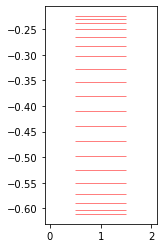

In [46]:
plt.figure(figsize = (2, 4))
plt.eventplot(f*eigenenergies, orientation = 'vertical', colors = 'r', linewidth = 0.5)
# This is the plot for the enegy levels!!
#Those are the energy descrietiesed bands
plt.show()